In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
# nltk.download("punkt") #如果没有punkt词库，可以现下载

# 加载新闻数据集
train_df = pd.read_csv("./data/train_news.csv")
test_df = pd.read_csv("./data/test_news.csv")


def preprocess(df, word2idx=None, label2idx=None, max_len=500):#当一段话单词数（包括标点）超过500的时候，截断该句；当单词数不足500时，在句子后面都补上统一的数字
    texts = df["text"].values
    labels = df["category"].values

    # 标签编码
    if label2idx is None:
        unique_labels = set(labels)
        print(unique_labels)
        label2idx = {label: idx for idx, label in enumerate(unique_labels)}
    labels = [label2idx[label] for label in labels]

    # 分词
    tokenized_texts = [word_tokenize(text.lower()) for text in texts]

    if word2idx is None:
        # 构建词汇表
        all_tokens = [token for text in tokenized_texts for token in text]
        vocab = Counter(all_tokens)
        vocab_size = 25000  #最多不会超过25000个词汇
        vocab = vocab.most_common(vocab_size - 2)
        word2idx = {word: idx + 2 for idx, (word, _) in enumerate(vocab)}
        word2idx["<unk>"] = 0
        word2idx["<pad>"] = 1

    # 数值化
    def encode_text(text):
        return [word2idx.get(word, word2idx["<unk>"]) for word in text]

    encoded_texts = [encode_text(text) for text in tokenized_texts]

    # 填充或截断
    padded_texts = [
        (
            text[:max_len]
            if len(text) > max_len
            else text + [word2idx["<pad>"]] * (max_len - len(text))
        )
        for text in encoded_texts
    ]

    return padded_texts, labels, word2idx, label2idx


# 划分训练集和测试集
X_train, y_train, word2idx, label2idx = preprocess(train_df)
X_test, y_test, _, _ = preprocess(test_df, word2idx, label2idx)
#print(X_test)

# 自定义Dataset类
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




{'tech', 'entertainment', 'sport', 'business'}


第1题答案与解题过程：

In [2]:
#打印Label的类别：
label_name = set(y_train)
print(label_name)
# 计算不同整数的数量
num_labels = len(label_name)
# 输出结果
print("label的取值可以有：",num_labels)


# 数出一个训练集中包含的不同单词数
# # 将二维数组展平为一个一维数组
flattened_array = [item for sublist in X_train for item in sublist]
# 使用集合去除重复的元素
unique_elements = set(flattened_array)
# 计算不同整数的数量
num_unique_elements = len(unique_elements)
print("训练集的Feature中包含的不同的单词（标点）数为：", num_unique_elements-1)

## 数出测试集中，新出现的单词数
# 初始化计数器
zero_count = 0
for row in X_test:
    for element in row:
        if element == 0:
            zero_count += 1
print("测试集中出现不识别的单词（标点）个数：", zero_count)
# # 将二维数组展平为一个一维数组
flattened_array = [item for sublist in X_test for item in sublist]
# 使用集合去除重复的元素
unique_elements = set(flattened_array)
# 计算不同整数的数量
num_unique_elements = len(unique_elements)
print("测试集的Feature中包含多少种可以识别的单词（标点）数为：", num_unique_elements-2) #去掉0和1，这两类

{0, 1, 2, 3}
label的取值可以有： 4
训练集的Feature中包含的不同的单词（标点）数为： 21737
测试集中出现不识别的单词（标点）个数： 2668
测试集的Feature中包含多少种可以识别的单词（标点）数为： 7457


第3题解题过程：

In [2]:
# 定义双向LSTM模型
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, pad_idx):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim,padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional = True) #双向LSTM关键修改位置
        self.fc = nn.Linear(2 * hidden_dim, num_classes) #双向LSTM关键修改位置

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, (hidden, cell) = self.lstm(embedded)
        # 我们只需要最后一个时间步的输出
        last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1) #双向LSTM关键修改位置
        logits = self.fc(last_hidden)
        return logits

# 模型参数
embedding_dim = 128
hidden_dim = 64
vocab_size = len(word2idx)
num_classes = 4
pad_idx = word2idx["<pad>"]

# 实例化模型
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, pad_idx)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = criterion.to(device)
num_epochs = 10
history = {"train_loss": [], "train_acc": []}
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / y.shape[0]
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        logits = model(inputs)
        loss = criterion(logits, targets)
        acc = categorical_accuracy(logits, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    history["train_loss"].append(epoch_loss / len(train_loader))
    history["train_acc"].append(epoch_acc / len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Xiao Ai Train Loss: {epoch_loss/len(train_loader):.4f}, Xiao Ai Train Accuracy: {epoch_acc/len(train_loader):.4f}')

# 在测试数据上评估模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        logits = model(inputs)
        _, predicted = torch.max(logits, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Xiao Ai Test Accuracy: {correct/total:.4f}')

C:\ProgramData\Anaconda3\envs\ai4engineeringcourse\lib\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


cpu
Epoch 1/10, Xiao Ai Train Loss: 1.3700, Xiao Ai Train Accuracy: 0.3051
Epoch 2/10, Xiao Ai Train Loss: 1.2922, Xiao Ai Train Accuracy: 0.4988
Epoch 3/10, Xiao Ai Train Loss: 1.2044, Xiao Ai Train Accuracy: 0.5623
Epoch 4/10, Xiao Ai Train Loss: 1.0802, Xiao Ai Train Accuracy: 0.6598
Epoch 5/10, Xiao Ai Train Loss: 0.8800, Xiao Ai Train Accuracy: 0.7723
Epoch 6/10, Xiao Ai Train Loss: 0.5799, Xiao Ai Train Accuracy: 0.8447
Epoch 7/10, Xiao Ai Train Loss: 0.3760, Xiao Ai Train Accuracy: 0.9139
Epoch 8/10, Xiao Ai Train Loss: 0.2637, Xiao Ai Train Accuracy: 0.9457
Epoch 9/10, Xiao Ai Train Loss: 0.1728, Xiao Ai Train Accuracy: 0.9695
Epoch 10/10, Xiao Ai Train Loss: 0.0967, Xiao Ai Train Accuracy: 0.9941
Xiao Ai Test Accuracy: 0.8450


第4题解题过程：

{'train_loss': [1.370019592344761, 1.2921572625637054, 1.2043834328651428, 1.0802407674491405, 0.8800261579453945, 0.5799197796732187, 0.3759685307741165, 0.26371709164232016, 0.17279035411775112, 0.09673604066483676], 'train_acc': [0.30507812462747097, 0.49882812425494194, 0.5623046867549419, 0.6597656235098839, 0.7722656242549419, 0.8447265625, 0.9138671867549419, 0.9457031264901161, 0.9695312492549419, 0.994140625]}


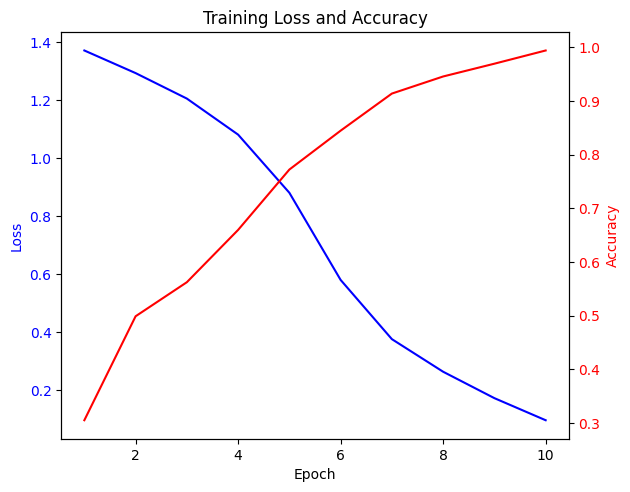

In [3]:
print(history)
def plot_training(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="blue")
    ax1.plot(epochs, history["train_loss"], color="blue", label="Train Loss")
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="red")
    ax2.plot(epochs, history["train_acc"], color="red", label="Train Accuracy")
    ax2.tick_params(axis="y", labelcolor="red")

    fig.tight_layout()
    plt.title("Training Loss and Accuracy")
    plt.show()
plot_training(history)

第5题解题过程：

In [5]:
def precision_recall_f1_method1(preds, labels, num_classes):
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    for p, t in zip(preds, labels):
        if p == t:
            true_positives[p] += 1
        else:
            false_positives[p] += 1
            false_negatives[t] += 1

    precisions = []
    recalls = []
    f1s = []
    for i in range(num_classes):
        precision = true_positives[i] / (true_positives[i] + false_positives[i] + 1e-10)
        recall = true_positives[i] / (true_positives[i] + false_negatives[i] + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return precisions, recalls, f1s

#直接使用sklearn中自带的函数，可以快速计算，这里是个trick，知道当然可以用
from sklearn.metrics import precision_recall_fscore_support
def precision_recall_f1_method2(preds, labels, num_classes):
    # 使用sklearn的precision_recall_fscore_support函数来计算精确率、召回率和F1分数
    precisions, recalls, f1_scores, _ = precision_recall_fscore_support(labels, preds, average=None, labels=range(num_classes))
    return precisions, recalls, f1_scores

def evaluate(model, dataloader, criterion, num_labels):
    model.eval()
    loss_total = 0
    correct_total = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            logits = model(inputs)
            loss = criterion(logits, targets)
            loss_total += loss.item() * targets.size(0)
            _, predicted = torch.max(logits, 1)
            total += targets.size(0)
            correct_total += (predicted == targets).sum().item()
            all_preds.extend(predicted.tolist())
            all_labels.extend(targets.tolist())

    avg_loss = loss_total / total
    avg_acc = correct_total / total

    precisions, recalls, f1s = precision_recall_f1_method1(all_preds, all_labels, num_labels)
    return avg_loss, avg_acc, precisions, recalls, f1s

# Assuming num_classes is known and defined
test_loss, test_acc, test_precisions, test_recalls, test_f1s = evaluate(model, test_loader, criterion, num_labels)

print(f"Xiao Ai Test Accuracy: {test_acc:.4f}")

for i in range(num_labels):
    print(
        f"Xiao Ai Category {list(label_name)[i]}: Precision: {test_precisions[i]:.4f}, Recall: {test_recalls[i]:.4f}, F1: {test_f1s[i]:.4f}"
    )

Xiao Ai Test Accuracy: 0.8450
Xiao Ai Category 0: Precision: 0.6923, Recall: 0.8372, F1: 0.7579
Xiao Ai Category 1: Precision: 0.8493, Recall: 0.9538, F1: 0.8986
Xiao Ai Category 2: Precision: 0.9355, Recall: 0.6591, F1: 0.7733
Xiao Ai Category 3: Precision: 0.9545, Recall: 0.8750, F1: 0.9130
